In [1]:
import pandas as pd
import matplotlib as plot
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import precision_score, accuracy_score, roc_curve, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


# Data Prep and Exploration

Load the data and do your initial preparation. 
1. How many observations and variables do you have?
2. Select a 25% sample of the data for use in testing.
3. Describe the distribution of the outcome variable. What is the majority class?
4. What is the accuracy, precision, and recall of the majority-class classifier on the test data?
5. Identify some variables that, based on your understanding and reading (e.g. the source paper!) are likely to be useful for predicting default. Describe them, your motivation, their distribution, and their relationship to outcomes (in the training data). Do feature transformations you find useful here as well. You may need to create interaction features, or do other feature transformations.


In [2]:
case = pd.read_csv('SBAcase.11.13.17.csv')  ##subset of national
national = pd.read_csv('SBAnational.csv', encoding='latin1')     ##Historical data from 1987-2014

/Users/bl4z3/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


*1. How many observations and variables do you have?*

Looking at the cell below, we can see that we have 899164 observations across 27 variables.

In [3]:
national.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

*2. Select a 25% sample of the data for use in testing.*

In [4]:
rng = np.random.RandomState(20201031)
test = national.sample(frac=0.25, random_state=rng)
train_mask = pd.Series(True, index=national.index)
train_mask[test.index] = False
train = national[train_mask].copy()
train.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,28-Feb-97,1997,...,N,N,NaN,30-Jun-97,"$517,000.00",$0.00,P I F,$0.00,"$517,000.00","$387,750.00"


*3. Describe the distribution of the outcome variable. What is the majority class?*

In this instance, 0 is paid in full, while 1 is charged off. When performing further operations, we can see that approximately 69% of the test cases have paid off the loan, while approximately 31% defaulated

In [5]:
test.MIS_Status.value_counts()

P I F     184948
CHGOFF     39336
Name: MIS_Status, dtype: int64

In [6]:
test.MIS_Status.value_counts()/test.MIS_Status.count()

P I F     0.824615
CHGOFF    0.175385
Name: MIS_Status, dtype: float64

*4. What is the accuracy, precision, and recall of the majority-class classifier on the test data?*

In [7]:
## TP = 184948 FP = 39336
## TN = 0 FN = 0
## Acc = (TP + TN)/(TP + FP + TN + FN)
## 184948/(184948+39336)
## Precision = TP/(TP + FP)
## 184948/(184948+39336)
## Recall = TP / (TP+FN)
## 184948/184948

*5. Identify some variables that, based on your understanding and reading (e.g. the source paper!) are likely to be useful for predicting default. Describe them, your motivation, their distribution, and their relationship to outcomes (in the training data). Do feature transformations you find useful here as well. You may need to create interaction features, or do other feature transformations.*

When reading through the paper, we can see 7 variables that have been identified as relating to risk. 

1. Location(state)
2. Industry(NAICS)
3. Gross Disbursement (DisbursementGross)
4. Loans Backed By Real Estate(RealEstate)
5. Economic Recession(Recession)
6. SAB's Guaranteed Portion of Approved Loan(SBA_Appv)
7. New or Existing Businesses

## Location

This variable seeks to not only define location, but specifically looks at location based on state (rather than city, or zipcode). I think that this variable is important, because looking at the default rate across states, we can see it is not uniform. Also, the recession impacted states differently.

In [8]:
states = {
        'AK': 1,
        'AL': 2,
        'AR': 3,
        'AS': 4,
        'AZ': 5,
        'CA': 6,
        'CO': 7,
        'CT': 8,
        'DC': 9,
        'DE': 10,
        'FL': 11,
        'GA': 12,
        'GU': 13,
        'HI': 14,
        'IA': 15,
        'ID': 16,
        'IL': 17,
        'IN': 18,
        'KS': 19,
        'KY': 20,
        'LA': 21,
        'MA': 22,
        'MD': 23,
        'ME': 24,
        'MI': 25,
        'MN': 26,
        'MO': 27,
        'MP': 28,
        'MS': 29,
        'MT': 30,
        'NA': 31,
        'NC': 32,
        'ND': 33,
        'NE': 34,
        'NH': 35,
        'NJ': 36,
        'NM': 37,
        'NV': 38,
        'NY': 39,
        'OH': 40,
        'OK': 41,
        'OR': 42,
        'PA': 43,
        'PR': 44,
        'RI': 45,
        'SC': 46,
        'SD': 47,
        'TN': 48,
        'TX': 49,
        'UT': 50,
        'VA': 51,
        'VI': 52,
        'VT': 53,
        'WA': 54,
        'WI': 55,
        'WV': 56,
        'WY': 57
}

In [9]:
def state_to_num(state):
    if state == state:
        return states[state]
    else:
        return 0


test['StateNum'] = test['State'].apply(state_to_num)
train['StateNum'] = train['State'].apply(state_to_num)

## Industry

This variable looks at the industry this loan is being used in. As the paper describes, there are numerous high risk industries, like food service, and low risk industries too; like medical service. When looking at the data in this dataset, we see that all loans are dealing with real estate. To granulate this feature, we choose to take the second set of double digits to find out which parts of real estate these business are operating from.

In [10]:
train['modNAICS'] = train['NAICS'].astype(str)
train['modNAICS'] = train['modNAICS'].str.slice(0, 4)
train['shortNAICS'] = train['modNAICS'].str.slice(0, 2)
train.modNAICS.value_counts()

0       151824
8111     24334
7221     21070
7222     17591
6213     12152
         ...  
4862         6
8131         5
4861         4
1124         1
9251         1
Name: modNAICS, Length: 354, dtype: int64

In [11]:
test['modNAICS'] = test['NAICS'].astype(str)
test['modNAICS'] = test['modNAICS'].str.slice(0, 4)
test['shortNAICS'] = test['modNAICS'].str.slice(0, 2)
test.modNAICS.value_counts()

0       50124
8111     8314
7221     6919
7222     5920
5617     4111
        ...  
4862        3
9251        3
5232        3
8131        1
9271        1
Name: modNAICS, Length: 353, dtype: int64

## Gross Disbursement

The idea of this being a risk evaluator is that, if a business qualifies for a larger loan, it bears to reason that they are more likely to succeed, as they have financial backing.

In [12]:
test.DisbursementGross.value_counts()
test['DGMod'] = (test['DisbursementGross'].replace( '[\$,)]','', regex=True )).astype(float)
train['DGMod'] = (train['DisbursementGross'].replace( '[\$,)]','', regex=True )).astype(float)

## Economic Recession

Whether or not a loan was issued during the great recession. Since this does not appear automatically, but rather must be transformed from DisbursementDate. Also, since these loans typically have a deadline of 5 years to pay off, anything generated within 5 years of the last entry should be removed.

In [13]:
len(test)

224791

In [14]:
from datetime import datetime
dates = train['DisbursementDate']
DateTime = []
TimeStamp = []
for entry in dates:
    if entry == entry :
        DateTime.append(datetime.strptime(entry, '%d-%b-%y'))
        TimeStamp.append(datetime.timestamp(datetime.strptime(entry, '%d-%b-%y')))
    else:
        DateTime.append(0)
        TimeStamp.append(0)
train['ModDate'] = DateTime
train['TimeStamp'] = TimeStamp
Start = datetime.strptime('2007-12-01', '%Y-%m-%d')
End = datetime.strptime('2009-06-30', '%Y-%m-%d')
StartTS = datetime.timestamp(Start)
EndTS = datetime.timestamp(End)
train['Recession'] = (train.TimeStamp > StartTS) & (train.TimeStamp <EndTS )

In [15]:
train.Recession.value_counts()

False    636513
True      37860
Name: Recession, dtype: int64

In [16]:
from datetime import datetime
dates = test['DisbursementDate']
DateTime = []
TimeStamp = []
for entry in dates:
    if entry == entry:
        DateTime.append(datetime.strptime(entry, '%d-%b-%y'))
        TimeStamp.append(datetime.timestamp(datetime.strptime(entry, '%d-%b-%y')))
    else:
        DateTime.append(0)
        TimeStamp.append(0)
test['ModDate'] = DateTime
test['TimeStamp'] = TimeStamp
## label all entries occuring in great recession
## Dec. 1, 2007 to June 30, 2009
Start = datetime.strptime('2007-12-01', '%Y-%m-%d')
End = datetime.strptime('2009-06-30', '%Y-%m-%d')
StartTS = datetime.timestamp(Start)
EndTS = datetime.timestamp(End)
test['Recession'] = (test.TimeStamp > StartTS) & (test.TimeStamp <EndTS )

In [17]:
test.Recession.value_counts()

False    212065
True      12726
Name: Recession, dtype: int64

## Backed By Real Estate

The paper demonstrates that loans backed by real estate default less, based on the idea that the real estate can be sold to reimburse the loan. However, we will have to preprocess the data in order to do this, based on Term (as real estate backed loans have terms greater than 240 months, typically).

In [18]:
test['RealEstate'] = test.Term >= 240
test.RealEstate.value_counts()

False    186713
True      38078
Name: RealEstate, dtype: int64

In [19]:
train['RealEstate'] = train.Term >= 240
train.RealEstate.value_counts()

False    560294
True     114079
Name: RealEstate, dtype: int64

# New/Existing Business

While this was initially excluded from my set of features, as the paper says that it does not signifigantly impact the classification, I decided to add it to determine that for myself.

In [20]:
test['NewNewExist'] = test.NewExist.replace(0, 1)
train['NewNewExist'] = train.NewExist.replace(0 , 1)



In [21]:
train.NewNewExist.value_counts() 


1.0    484502
2.0    189774
Name: NewNewExist, dtype: int64

In [22]:
test['NewNewExist'] = test.NewNewExist.replace(1, 0)
train['NewNewExist'] = train.NewNewExist.replace(1, 0)
test['NewNewExist'] = test.NewNewExist.replace(2, 1)
train['NewNewExist'] = train.NewNewExist.replace(2, 1)

In [23]:
test['NewNewExist'] = test['NewNewExist'].fillna(0)
train['NewNewExist'] = train['NewNewExist'].fillna(0)

## SBA's Guaranteed Portion of Approved Loan

This deals with the amount that the SBA approves, compared to the gross amount approved by the bank. I don't know why this is a feature, but it is shown to be important in the paper

In [24]:
from re import sub
from decimal import Decimal
import numpy as np

SBBA = train.SBA_Appv
SBBAList = []
for entry in SBBA:
    SBBAList.append(Decimal(sub(r'[^\d.]', '', entry)))
SBBAList = np.array(SBBAList)
GA = train.GrAppv
GAList = []
for entry in GA:
    GAList.append(Decimal(sub(r'[^\d.]', '', entry)))
GAList = np.array(GAList)
    
train['SBAPortion'] = pd.Series(SBBAList) / pd.Series(GAList) 
train['SBAPortion'] = train['SBAPortion'].fillna(0)

In [25]:
from re import sub
from decimal import Decimal
import numpy as np

SBBA = test.SBA_Appv
SBBAList = []
for entry in SBBA:
    SBBAList.append(Decimal(sub(r'[^\d.]', '', entry)))
SBBAList = np.array(SBBAList)
GA = test.GrAppv
GAList = []
for entry in GA:
    GAList.append(Decimal(sub(r'[^\d.]', '', entry)))
GAList = np.array(GAList)
    
test['SBAPortion'] = pd.Series(SBBAList) / pd.Series(GAList) 
test['SBAPortion'] = test['SBAPortion'].fillna(0)

In [26]:
test['SBAPortion'].head(50)

143344    0.82
122707     0.9
773187       0
643105       0
121661     0.9
44592        1
603535       0
176043     0.5
506270       0
473304       0
838069       0
328728       0
749959       0
366684       0
36495     0.75
334144       0
360109       0
319832       0
488520       0
6818       0.9
251953       0
573842       0
614542       0
50322      0.5
520628       0
475164       0
519453       0
656243       0
435105       0
53865     0.75
190809    0.75
727459       0
375868       0
853594       0
365772       0
259213       0
317131       0
802400       0
401264       0
494287       0
140331    0.75
386908       0
245553       0
248570       0
520868       0
131946     0.5
276047       0
558257       0
855691       0
350272       0
Name: SBAPortion, dtype: object

## Extraneous Preprocessing

In order to make this dataset classifiable, we have to convert the MIS_Status to a binary value.

In [27]:
test['Default'] = test['MIS_Status'] == 'P I F'
test['Default'] = test.Default.replace(True, 1)
train['Default'] = train['MIS_Status'] == 'P I F'
train['Default'] = train.Default.replace(True, 1)

In [28]:
test.Default.value_counts() + train.Default.value_counts()

1.0    739609
0.0    159555
Name: Default, dtype: int64

In [29]:
national.MIS_Status.value_counts()

P I F     739609
CHGOFF    157558
Name: MIS_Status, dtype: int64

# Subset Model

Subset Model (15%)

Subset your training and test data to only include data from California, for business with NAICS codes starting with 53 (Real Estate and Rental and Leasing).

Build a logistic regression model using no more than 5 features to predict default on this subset. Likely useful features include whether it is a new business, a real estate transaction, the proportion guaranteed by SBA, and whether it was active during the recession.

If you want to experiment with different features, create a tuning set that is a subset of the training set, and use it to evaluate the accuracy of your model with them. Test the final accuracy of one model on the test data using the accuracy metric.

In [30]:
subsetTest = test[test["State"] == 'CA']
subsetTest = subsetTest[subsetTest['shortNAICS'] == '53']
subsetTrain = train[train["State"] == 'CA']
subsetTrain = subsetTrain[subsetTrain['shortNAICS'] == '53']

In [31]:
feat_cols = ['RealEstate',
    'Recession',
    'shortNAICS',
    'DGMod',
    'SBAPortion'       ]
out_col = 'Default'

train_x = subsetTrain[feat_cols]
train_y = subsetTrain[out_col]
test_x = subsetTest[feat_cols]
test_y = subsetTest[out_col]

In [32]:
test_y.value_counts()/test_y.count()

1.0    0.718929
0.0    0.281071
Name: Default, dtype: float64

In [33]:
power_pipe2 = Pipeline([
    ('standardize', PowerTransformer()),
    ('classify', LogisticRegression(penalty='none', solver='saga'))
])

power_pipe2.fit(train_x, train_y)

print(accuracy_score(test_y, power_pipe2.predict(test_x)))
print(precision_score(test_y, power_pipe2.predict(test_x)))

0.7131931166347992
0.739406779661017


/Users/bl4z3/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


# Full Model

Extend your model from the subset data set (California/53) to the full data set. Do you need to add state & industry terms? Do you need to use interaction terms?

Use a tuning set to make these decisions. Test one model from this section on the test data.

In [34]:
accuracy = []
precision = []
recall = []
specificity = []
costArr = []
fprArr = []
newPrecision = []
newFPRArr = []
existingPrecision = []
existingFPRArr = []

In [35]:
rng = np.random.RandomState(20201031)

subset =  test.sample(frac=0.25, random_state=rng)
subsetTest = subset.sample(frac=0.25, random_state=rng)
subsetTrain_mask = pd.Series(True, index=subset.index)
subsetTrain_mask[subsetTest.index] = False
subsetTrain = subset[subsetTrain_mask].copy()


feat_cols = [
    #'RealEstate',
    'Recession',
    'modNAICS',
    'DGMod',
    'NewNewExist',
    #'NAICS',
    #'SBAPortion',
    'StateNum'
   
]
out_col = 'Default'

train_x = subsetTrain[feat_cols]
train_y = subsetTrain[out_col]
test_x = subsetTest[feat_cols]
test_y = subsetTest[out_col]

#print(subsetTrain.Default.value_counts()/subsetTrain.Default.count())

pure_pipeL2 = Pipeline([
    ('standardize', StandardScaler()),
    ('classify', LogisticRegression(penalty='none'))
])

pure_pipeL2.fit(train_x, train_y)


Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classify',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='none', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [36]:
feat_cols = [
    #'RealEstate',
    'Recession',
    'modNAICS',
    'DGMod',
    'NewNewExist',
    #'NAICS',
    #'SBAPortion',
    'StateNum'
   
]
out_col = 'Default'

train_x = train[feat_cols]
train_y = train[out_col]
test_x = test[feat_cols]
test_y = test[out_col]

In [37]:
pure_pipeL2 = Pipeline([
    ('standardize', StandardScaler()),
    (('classify', LogisticRegression(penalty='none')))
])
pure_pipeL2.fit(train_x, train_y)
acc =  accuracy_score(test_y, pure_pipeL2.predict(test_x))
prec = precision_score(test_y, pure_pipeL2.predict(test_x))
rec = recall_score(test_y, pure_pipeL2.predict(test_x))
tn, fp, fn, tp = confusion_matrix(test_y, pure_pipeL2.predict(test_x)).ravel()
spec = tn / (tn+fp)
cost = (fp*5) + (fn)
fpr = fp

testList = np.array(test_x['NewNewExist'].tolist()).astype(int)
new = np.argwhere(testList == 1)
existing = np.argwhere(testList == 0)
prediction = pure_pipeL2.predict(test_x)
new_test_x = np.take(prediction, new)
np.array(test_y.tolist())
new_test_y = np.take(np.array(test_y.tolist()).astype(int), new)
existing_test_x = np.take(prediction, existing)
existing_test_y = np.take(np.array(test_y.tolist()).astype(int), existing)

newPrec = precision_score(new_test_y, new_test_x)
ntn, nfp, nfn, ntp = confusion_matrix(new_test_y, new_test_x).ravel()
newFPR = nfp
existingPrec = precision_score(existing_test_y, existing_test_x)
etn, efp, efn, etp = confusion_matrix(existing_test_y, existing_test_x).ravel()
existingFPR = efp

accuracy.append(acc)
precision.append(prec)
recall.append(rec) 
specificity.append(spec)
costArr.append(cost) 
fprArr.append(fpr) 
newPrecision.append(newPrec) 
newFPRArr.append(newFPR) 
existingPrecision.append(existingPrec) 
existingFPRArr.append(existingFPR) 


# Lasso Regression 

Use a lasso regression (penalty='lasso' in LogisticRegression) to train a model with many features and automatically select the most useful ones. Use either a tuning set or LogisticRegressionCV to select a useful value for there regularization strength (C).

Note that while lasso regression will automatically select features, it can only work with the features you give it — you still need to transform data into useful form for influencing the predictor.

You might want to experiment with some more or different features on a tuning set!

Test one model from this section on the test data.

In [38]:
# test = national.sample(frac=0.25, random_state=rng)
# train_mask = pd.Series(True, index=national.index)
# train_mask[test.index] = False
# train = national[train_mask].copy()
# train.head()
rng = np.random.RandomState(20201031)

subset =  test.sample(frac=0.25, random_state=rng)
subsetTest = subset.sample(frac=0.25, random_state=rng)
subsetTrain_mask = pd.Series(True, index=subset.index)
subsetTrain_mask[subsetTest.index] = False
subsetTrain = subset[subsetTrain_mask].copy()


feat_cols = [
    'RealEstate',
    'Recession',
    'modNAICS',
    'DGMod',
    'NewNewExist',
    #'NAICS',
    #'SBAPortion',
    'StateNum'
   
]
out_col = 'Default'

train_x = subsetTrain[feat_cols]
train_y = subsetTrain[out_col]
test_x = subsetTest[feat_cols]
test_y = subsetTest[out_col]

print(subsetTrain.Default.value_counts()/subsetTrain.Default.count())

pure_pipeL2 = Pipeline([
    ('standardize', PowerTransformer()),
    ('classify', LogisticRegression(C = 1, penalty='l1', solver = 'liblinear'))
])

pure_pipeL2.fit(train_x, train_y)
print(accuracy_score(test_y, pure_pipeL2.predict(test_x)))
print(precision_score(test_y, pure_pipeL2.predict(test_x)))

1.0    0.824238
0.0    0.175762
Name: Default, dtype: float64
0.8215658362989324
0.8221493261071098


In [39]:
feat_cols = [
    #'RealEstate',
    'Recession',
    'modNAICS',
    'DGMod',
    'NewNewExist',
    #'NAICS',
    #'SBAPortion',
    'StateNum'
   
]
out_col = 'Default'

train_x = train[feat_cols]
train_y = train[out_col]
test_x = test[feat_cols]
test_y = test[out_col]



pure_pipeL2 = Pipeline([
    ('standardize', PowerTransformer()),
    ('classify', LogisticRegressionCV( penalty='l1', solver='liblinear'))
])
pure_pipeL2.fit(train_x, train_y)
acc =  accuracy_score(test_y, pure_pipeL2.predict(test_x))
prec = precision_score(test_y, pure_pipeL2.predict(test_x))
rec = recall_score(test_y, pure_pipeL2.predict(test_x))
tn, fp, fn, tp = confusion_matrix(test_y, pure_pipeL2.predict(test_x)).ravel()
spec = tn / (tn+fp)
cost = (fp*5) + (fn)
fpr = fp

testList = np.array(test_x['NewNewExist'].tolist()).astype(int)
new = np.argwhere(testList == 1)
existing = np.argwhere(testList == 0)
prediction = pure_pipeL2.predict(test_x)
new_test_x = np.take(prediction, new)
np.array(test_y.tolist())
new_test_y = np.take(np.array(test_y.tolist()).astype(int), new)
existing_test_x = np.take(prediction, existing)
existing_test_y = np.take(np.array(test_y.tolist()).astype(int), existing)

newPrec = precision_score(new_test_y, new_test_x)
ntn, nfp, nfn, ntp = confusion_matrix(new_test_y, new_test_x).ravel()
newFPR = nfp
existingPrec = precision_score(existing_test_y, existing_test_x)
etn, efp, efn, etp = confusion_matrix(existing_test_y, existing_test_x).ravel()
existingFPR = efp

accuracy.append(acc)
precision.append(prec)
recall.append(rec) 
specificity.append(spec)
costArr.append(cost) 
fprArr.append(fpr) 
newPrecision.append(newPrec) 
newFPRArr.append(newFPR) 
existingPrecision.append(existingPrec) 
existingFPRArr.append(existingFPR) 

# ElasticNet 

Extend from Lasso to ElasticNet (penalty='elasticnet', you will also need solver='saga' and to pass a list of L1 ratios to LogisticRegressionCV if you use it).

Again, test one model on the test data.

In [40]:
rng = np.random.RandomState(20201031)

subset =  test.sample(frac=0.25, random_state=rng)
subsetTest = subset.sample(frac=0.25, random_state=rng)
subsetTrain_mask = pd.Series(True, index=subset.index)
subsetTrain_mask[subsetTest.index] = False
subsetTrain = subset[subsetTrain_mask].copy()


feat_cols = [
    'RealEstate',
    'Recession',
    'modNAICS',
    'DGMod',
    'NewNewExist',
    'NAICS',
    'SBAPortion',
    'StateNum'
   
]
out_col = 'Default'

train_x = subsetTrain[feat_cols]
train_y = subsetTrain[out_col]
test_x = subsetTest[feat_cols]
test_y = subsetTest[out_col]

print(subsetTrain.Default.value_counts()/subsetTrain.Default.count())

pure_pipeL2 = Pipeline([
    ('standardize', PowerTransformer()),
    ('classify', LogisticRegressionCV(penalty='elasticnet', solver='saga', l1_ratios=np.linspace(0, 1, 5)))
])
pure_pipeL2.fit(train_x, train_y)
print(accuracy_score(test_y, pure_pipeL2.predict(test_x)))
print(precision_score(test_y, pure_pipeL2.predict(test_x)))

1.0    0.824238
0.0    0.175762
Name: Default, dtype: float64
0.8216370106761566
0.8216116173120729


In [41]:
feat_cols = [
    'RealEstate',
    'Recession',
    'modNAICS',
    'DGMod',
    'NewNewExist',
    'NAICS',
    'SBAPortion',
    'StateNum'
   
]
out_col = 'Default'

train_x = train[feat_cols]
train_y = train[out_col]
test_x = test[feat_cols]
test_y = test[out_col]



pure_pipeL2 = Pipeline([
    ('standardize', PowerTransformer()),
    ('classify', LogisticRegressionCV(penalty='elasticnet', solver='saga', l1_ratios=np.linspace(0, 1, 5)))
])
pure_pipeL2.fit(train_x, train_y)
acc =  accuracy_score(test_y, pure_pipeL2.predict(test_x))
prec = precision_score(test_y, pure_pipeL2.predict(test_x))
rec = recall_score(test_y, pure_pipeL2.predict(test_x))
tn, fp, fn, tp = confusion_matrix(test_y, pure_pipeL2.predict(test_x)).ravel()
spec = tn / (tn+fp)
cost = (fp*5) + (fn)
fpr = fp

testList = np.array(test_x['NewNewExist'].tolist()).astype(int)
new = np.argwhere(testList == 1)
existing = np.argwhere(testList == 0)
prediction = pure_pipeL2.predict(test_x)
new_test_x = np.take(prediction, new)
np.array(test_y.tolist())
new_test_y = np.take(np.array(test_y.tolist()).astype(int), new)
existing_test_x = np.take(prediction, existing)
existing_test_y = np.take(np.array(test_y.tolist()).astype(int), existing)

newPrec = precision_score(new_test_y, new_test_x)
ntn, nfp, nfn, ntp = confusion_matrix(new_test_y, new_test_x).ravel()
newFPR = nfp
existingPrec = precision_score(existing_test_y, existing_test_x)
etn, efp, efn, etp = confusion_matrix(existing_test_y, existing_test_x).ravel()
existingFPR = efp

accuracy.append(acc)
precision.append(prec)
recall.append(rec) 
specificity.append(spec)
costArr.append(cost) 
fprArr.append(fpr) 
newPrecision.append(newPrec) 
newFPRArr.append(newFPR) 
existingPrecision.append(existingPrec) 
existingFPRArr.append(existingFPR) 

# Random Forest

Let's try one more classifier: a random forest (RandomForestClassifier). Consider trying different hyperparameters, such as the number of estimators, with some tuning data.

Test one random forest model on the test data.

In [42]:
rng = np.random.RandomState(20201031)

subset =  test.sample(frac=0.25, random_state=rng)
subsetTest = subset.sample(frac=0.25, random_state=rng)
subsetTrain_mask = pd.Series(True, index=subset.index)
subsetTrain_mask[subsetTest.index] = False
subsetTrain = subset[subsetTrain_mask].copy()

feat_cols = [
    'RealEstate',
    'Recession',
    'modNAICS',
    'DGMod',
    'NewNewExist',
    'NAICS',
    'SBAPortion',
    'StateNum'
   
]

out_col = 'Default'

train_x = subsetTrain[feat_cols]
train_y = subsetTrain[out_col]
test_x = subsetTest[feat_cols]
test_y = subsetTest[out_col]

print(subsetTrain.Default.value_counts()/subsetTrain.Default.count())

pure_pipeL2 = Pipeline([
    ('standardize', StandardScaler()),
    ('classify', RandomForestClassifier(max_depth = 10, n_estimators= 100))
    ])
pure_pipeL2.fit(train_x, train_y)
print(accuracy_score(test_y, pure_pipeL2.predict(test_x)))
print(precision_score(test_y, pure_pipeL2.predict(test_x)))

1.0    0.824238
0.0    0.175762
Name: Default, dtype: float64
0.8265480427046263
0.8278245841434435


In [43]:
feat_cols = ['RealEstate',
    'Recession',
    'modNAICS',
    'DGMod',
    'SBAPortion',
    'NAICS',
    'StateNum']

out_col = 'Default'

train_x = train[feat_cols]
train_y = train[out_col]
test_x = test[feat_cols]
test_y = test[out_col]
newExist = test['NewNewExist']


pure_pipeL2 = Pipeline([
    ('standardize', StandardScaler()),
    ('classify', RandomForestClassifier(max_depth = 10, n_estimators= 100))
    ])
pure_pipeL2.fit(train_x, train_y)
acc =  accuracy_score(test_y, pure_pipeL2.predict(test_x))
prec = precision_score(test_y, pure_pipeL2.predict(test_x))
rec = recall_score(test_y, pure_pipeL2.predict(test_x))
tn, fp, fn, tp = confusion_matrix(test_y, pure_pipeL2.predict(test_x)).ravel()
spec = tn / (tn+fp)
cost = (fp*5) + (fn)
fpr = fp

testList = np.array(test['NewNewExist'].tolist()).astype(int)
new = np.argwhere(testList == 1)
existing = np.argwhere(testList == 0)
prediction = pure_pipeL2.predict(test_x)
new_test_x = np.take(prediction, new)
np.array(test_y.tolist())
new_test_y = np.take(np.array(test_y.tolist()).astype(int), new)
existing_test_x = np.take(prediction, existing)
existing_test_y = np.take(np.array(test_y.tolist()).astype(int), existing)

newPrec = precision_score(new_test_y, new_test_x)
ntn, nfp, nfn, ntp = confusion_matrix(new_test_y, new_test_x).ravel()
newFPR = nfp
existingPrec = precision_score(existing_test_y, existing_test_x)
etn, efp, efn, etp = confusion_matrix(existing_test_y, existing_test_x).ravel()
existingFPR = efp

accuracy.append(acc)
precision.append(prec)
recall.append(rec) 
specificity.append(spec)
costArr.append(cost) 
fprArr.append(fpr) 
newPrecision.append(newPrec) 
newFPRArr.append(newFPR) 
existingPrecision.append(existingPrec) 
existingFPRArr.append(existingFPR) 

# Final Summary 

To wrap up, show the relative performance of your different models on the test data in a single chart (a bar chart or dot plot). Do so with the following metrics:

    Accuracy
    Precision
    Recall / Sensitivity
    Specificity

Accuracy counts false positives and false negatives as equal errors, but in reality they do not have the same cost. Compute the cost of each classifier by assigning a cost of 5 to a false negative (classified as low-risk but defaulted), 1 to a false positive, and 0 to correct classifications. Show the cost of your different models in an appropriate chart.

Finally, show overall the false positive rate for your different models. Then break down the false positive rate and the precision by business status, and show each model's FPR and precision for new and existing businesses separately (I recommend a bar charts with model on the X axis, FPR or precision on the y, and different bar colors for new and existing businesses). Does your model perform comparably well for new and existing businesses?



In [44]:
allModels =pd.DataFrame(data=accuracy,    # values
...              index=['FullModel', 'LassoRegression', 'ElasticNet','RandomForest'],    # 1st column as index
...              columns=['accuracy']) 

In [45]:
allModels['precision'] = precision
allModels['recall'] = recall
allModels['specificity'] = specificity
allModels['cost'] = costArr
allModels['fpr'] =  fprArr
allModels['newPrecision'] = newPrecision
allModels['newFPRArr'] = newFPRArr
allModels['existingPrecision'] = existingPrecision
allModels['existingFPRArr'] = existingFPRArr

In [46]:
allModels

,accuracy,precision,recall,specificity,cost,fpr,newPrecision,newFPRArr,existingPrecision,existingFPRArr
FullModel,0.822751,0.822755,0.999995,0.000000,199216,39843,0.808161,12153,0.828481,27690
LassoRegression,0.823067,0.823012,1.000000,0.001757,198865,39773,0.808496,12127,0.828707,27646
ElasticNet,0.822813,0.822803,1.000000,0.000326,199150,39830,0.808202,12150,0.828532,27680
RandomForest,0.824784,0.825051,0.998838,0.016841,196075,39172,0.810090,11985,0.830922,27187


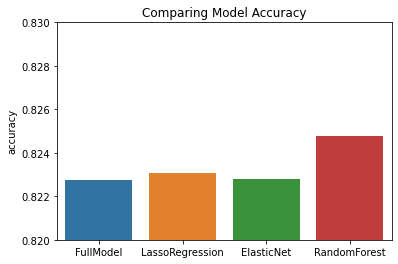

In [47]:
a_plot = sns.barplot(x = allModels.index, y = 'accuracy', data = allModels)
a_plot.set(ylim=(.82, .83))
a_plot.set_title("Comparing Model Accuracy")
plt.show()

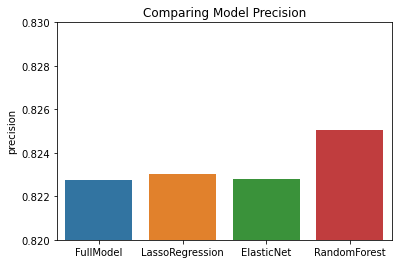

In [49]:
a_plot = sns.barplot(x = allModels.index, y = 'precision', data = allModels)
a_plot.set(ylim=(.82, .83))
a_plot.set_title("Comparing Model Precision")
plt.show()

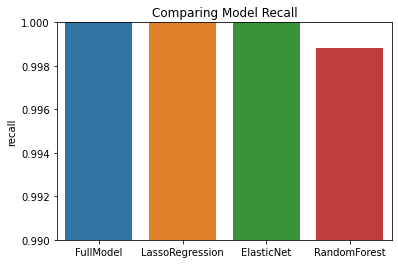

In [50]:
a_plot = sns.barplot(x = allModels.index, y = 'recall', data = allModels)
a_plot.set(ylim=(.99, 1))
a_plot.set_title("Comparing Model Recall")
plt.show()

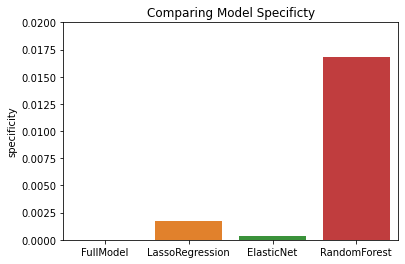

In [51]:
a_plot = sns.barplot(x = allModels.index, y = 'specificity', data = allModels)
a_plot.set(ylim=(0, .02))
a_plot.set_title("Comparing Model Specificty")
plt.show()

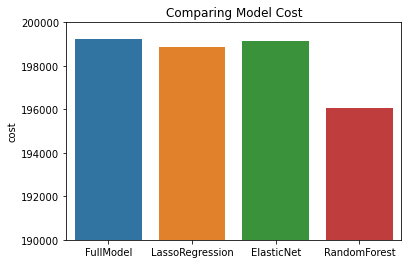

In [52]:
a_plot = sns.barplot(x = allModels.index, y = 'cost', data = allModels)
a_plot.set(ylim=(190000, 200000))
a_plot.set_title("Comparing Model Cost")
plt.show()

<AxesSubplot:label='0f3008e6-f438-4730-bd85-a6482d5461fb', ylabel='newPrecision'>

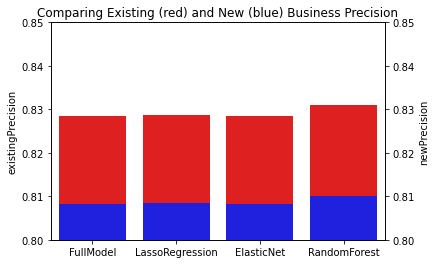

In [53]:
# a_plot = sns.barplot(x = allModels.index, y = 'newPrecision', data = allModels)
# a_plot.set(ylim=(39000, 40000))
# a_plot.set_title("Comparing Model False Positive Rate")
# plt.show()

import matplotlib.pyplot as plt
a_plot = sns.barplot(x = allModels.index, y = 'existingPrecision', color="r", data = allModels)
a_plot.set(ylim=(.8, .85))
a_plot.set_title("Comparing Existing (red) and New (blue) Business Precision")
ax2 = plt.twinx()
ax2.set(ylim=(.8, .85))
sns.barplot(x = allModels.index, y = 'newPrecision', data=allModels, color="b", ax=ax2)

The above chart demonstrates that models tend to have higher precision predicting whether existing business will default on their loans, compared to new businesses.

*Write 2-3 paragraphs about what you learn about your model performance and the usefulness of different features.*

When looking at the results highlighted in the charts above, it is easy to see which of these models performed the best, and which of them performed not so amazing. Clearly the random forest is the best of the lot, but it is also the most different model. Even though it is performing binary classification, the fact that it is an ensemble model probably highlights why ensemble models can perform so well. Though, I noticed taht even with Lasso regression, I had to manually select features, as throwing all the features at the classification performs worse results, as seen in Elastic net. Though, what I really think would have improved the results of all of these is further feature selection.

Going into this homework assignment, I leaned heavily on the features described in the paper. Further more, the paper specifically states that these features may or may not work, hence the existence of a FICO score. At first I didn't even include New/Existing Business into my feature set because of the paper, but then later added it to see how it would affect the results. Given more time, I would investigate a lot more features to see how they could potentially impact performance. Maybe zip codes? Urban or Rural? Jobs generated? Because a lot of the things I thought would have a big impact, like NAICS, didn't seem to cause that much of a difference, while Modified NAICS, a less specific variable, did. That makes me think that maybe there is too much granularity in some of these variables, and in addressing that could lead to improved effectiveness.